### 库导入

In [22]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from typing import Union
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat

### 路径定义

In [23]:
root = '.'
# raw_data_root = os.path.join(root, 'None')
data_folder = os.path.join(root, 'dataset')
fc_data_folder = os.path.join(data_folder, 'fc_data')
math_data_url = os.path.join(data_folder, 'math_data')
projection_url = os.path.join(root, 'references', 'networks_projection.csv')
img_save_folder = os.path.join(root, 'imgs')

### 环境变量

In [42]:
NODES_RANGE = range(1, 269)
NETWORKS = {1: 'Medial frontal', 2: 'Frontoparietal', 3: 'Default mode', 4: 'Subcortical-cerebellum', 5: 'Motor', 6: 'Visual I', 7: 'Visual Ⅱ', 8: 'Visual association'}
FC_KEYS = ['FC_mat']
MATH_KEYS = {'math': ['behav_math'], 'ID': ['cov_ID2'], 'gender': ['cov_gender'], 'grade': ['cov_grade']}

In [37]:
# 获取映射关系
projection = pd.read_csv(projection_url)
projection.head()

,Node,Network
0,1,2
1,2,4
2,3,3
3,4,2
4,5,3


### 函数定义

In [26]:
# # 从Excel数据中提取特定表数据
# def get_slice_fc(fc_bart:pd.DataFrame, slice:int):
#     """
#     Describe:
#         get fc of a slice from fc_bart.
#     Input:
#         fc_bart: pd.DataFrame
#         slice: int
#     Output:
#         sheet: pd.DataFrame
#     """
#     # get all sheet names
#     slice_names = fc_bart.sheet_names
#     slice_name = 'Slice_' + str(slice)
#     if slice_name not in slice_names:
#         raise ValueError(f'Slice not found, Slice from {slice_names[1]} to {slice_names[-1]}')
#     # get the sheet of the slice
#     sheet = fc_bart.parse(slice_name, header=None)
#     # set headers and idx like 'Voxel1'
#     sheet.columns = ['Voxel' + str(i) for i in range(1, sheet.shape[1] + 1)]
#     sheet.index = ['Voxel' + str(i) for i in range(1, sheet.shape[0] + 1)]
    
#     return sheet

In [27]:
# # 加载数据
# def load_data(data_path: str) -> pd.DataFrame:
#     if not os.path.exists(data_path):
#         raise FileNotFoundError(f"file not found: {data_path}")
    
#     if data_path.endswith(".csv"):
#         df = pd.read_csv(data_path)
#     elif data_path.endswith(".xlsx"):
#         df = pd.ExcelFile(data_path)
#         if len(df.sheet_names) == 1:
#             df = df.parse(df.sheet_names[0], header=None)
    
#     return df

In [28]:
# 获取指定目录下的所有文件名
def get_files(path: str, suffix: Union[str, list]=None) -> list:
    """
    Describe:
        get all files under the path with the specified suffix.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"file not found: {path}")
    
    if isinstance(suffix, str):
        suffix = [suffix]
    if suffix is None:
        suffix = []
    
    files = []
    for root, dirs, filenames in os.walk(path):
        for filename in filenames:
            if filename.split('.')[-1] in suffix:
                files.append(os.path.join(root, filename))

    return files

In [38]:
# 读取.mat数据
def load_mat(mat_path: str, *args) -> np.array:
    """
    Describe:
        load .mat file to numpy array.
    Input:
        mat_path: str
    Output:
        data: np.array
    """
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"file not found: {mat_path}")
    
    mat = loadmat(mat_path)

    # # 打印各个变量的维度
    # for key, value in mat.items():
    #     if isinstance(value, np.ndarray):
    #         print(f"{key}: {value.shape}")
    # return

    # transform to numpy array
    if len(args) == 1:
        data = mat[args[0]]
    elif len(args) > 1:
        data = {key:mat[key] for key in args}
    else:
        raise ValueError("key must be specified.")
    
    return data

In [30]:
# 将numpy array转为pandas DataFrame
def array2df(data: np.array, columns:list=None, 
idx:list=None) -> pd.DataFrame:
    """
    Describe:
        transform numpy array to pandas DataFrame.
    Input:
        data: np.array
        columns: list
        idx: list
    Output:
        df: pd.DataFrame
    """
    if isinstance(data, np.ndarray):
        # check dimensions
        if data.ndim > 2:
            raise ValueError(f"Data dimensions should be less than 3, but got {data.ndim}")
        
        if columns:
            if len(columns) != data.shape[1]:
                raise ValueError(f"Columns length should be equal to data's second dimension{data.shape[1]}, but got {len(columns)}")
        if idx:
            if len(idx) != data.shape[0]:
                raise ValueError(f"Index length should be equal to data's first dimension{data.shape[0]}, but got {len(idx)}")
            
        df = pd.DataFrame(data, columns=columns, index=idx)
        return df

In [31]:
# 将对称的fc矩阵变为下三角阵，上三角阵置为0
def reset_fc_matrix(fc_matrix: Union[pd.DataFrame, np.ndarray]):
    """
    Describe:
        reset fc matrix to lower triangle matrix.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    n = fc_matrix.shape[0]
    new_fc_matrix = fc_matrix.copy()
    for i in range(n):
        for j in range(i+1, n):
            new_fc_matrix[j, i] = 0
    return pd.DataFrame(new_fc_matrix)

In [32]:
# 使用fsl绘制fc矩阵的热图
def plot_fc_heatmap(fc_matrix: Union[pd.DataFrame, np.ndarray], xlabel:str=None, ylabel:str=None, title:str='default', output:str=None):
    """
    Describe:
        plot fc matrix heatmap.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
        output: str
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(fc_matrix, cmap='coolwarm', center=0, square=True)

    if xlabel:
        plt.xlabel(xlabel)
        plt.xticks([])
    if ylabel:
        plt.ylabel(ylabel)
        plt.yticks([])

    plt.title(title)

    if output:
        if not output.endswith('.png'):
            output += '.png'
        plt.savefig(output)
    # plt.close()

In [33]:
# node到network的映射方法
def node2network(projection_set:pd.DataFrame, node:int=None, n_networks:int=None, only_idx:bool=True, data:pd.DataFrame=None)->Union[pd.DataFrame|tuple]:
    """
    Describe:
        node to network mapping.
        if set node, return the network of the node.
        if set n_networks, return the nodes of the network.
        if only_idx is True, only return the corresponding index of input.
        if data is set, return the corresponding data of the input with its shape.
    Args:
        projection_set: pd.DataFrame
        node: int
        n_networks: int
        only_idx: bool
        data: pd.DataFrame
    Returns:
        pd.DataFrame, tuple
    """
    
    
    

### 数据概览

In [34]:
# get files
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [50]:
# load data
fc_bart = load_mat(fc_files[0], *FC_KEYS)
math_scores = load_mat(math_files[0], *MATH_KEYS['math'])
fc_bart.shape, math_scores.shape

((268, 268, 256), (256, 1))

In [ ]:
# transform to DataFrame
fc_bart0 = array2df(fc_bart[:, :, 0], columns=NODES_RANGE, idx=NODES_RANGE)
math_scores = array2df(math_scores, columns=['math'])
fc_bart0.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
1,0.000000,0.189802,0.069788,0.568443,-0.051055,0.084177,0.121438,0.100414,0.136643,0.002919,...,0.103814,0.123213,0.042259,-0.164516,0.057977,0.095939,-0.109077,0.068935,-0.111793,0.039415
2,0.189802,0.000000,0.124568,0.367421,-0.018599,0.111053,0.261236,0.214775,0.368923,0.108056,...,0.032008,0.024696,-0.126780,-0.193520,-0.039542,0.206792,0.007187,0.080524,0.078196,0.156316
3,0.069788,0.124568,0.000000,0.201776,0.491616,0.466779,0.012776,0.043237,-0.289219,0.310717,...,0.161461,-0.134780,-0.214065,0.093457,-0.112219,-0.061851,0.017956,0.314763,-0.007274,0.151609
4,0.568443,0.367421,0.201776,0.000000,0.008775,0.088734,0.141554,0.189478,0.260300,-0.020948,...,-0.006560,-0.011814,-0.028641,0.076460,0.174911,0.121340,0.140456,0.056090,-0.073411,0.211879
5,-0.051055,-0.018599,0.491616,0.008775,0.000000,0.817163,0.118583,-0.060368,-0.186405,0.681545,...,0.601778,-0.098924,0.062315,0.215823,-0.062209,-0.279950,0.087016,-0.001206,0.135118,-0.050122


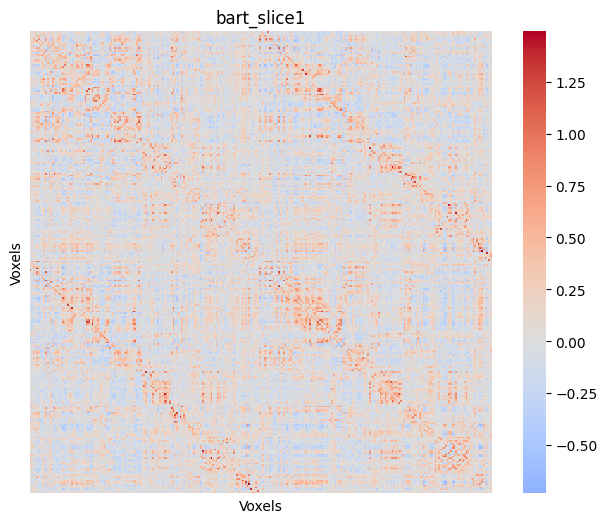

In [52]:
plot_fc_heatmap(fc_bart0, xlabel='Voxels', ylabel='Voxels', title='bart_slice1', output=os.path.join(img_save_folder, 'bart_slice1.png'))

In [53]:
math_scores.head()

,math
0,558.50
1,510.24
2,558.50
3,393.82
4,477.30


In [54]:
math_scores.describe()

,math
count,256.000000
mean,531.630000
std,100.976196
min,292.990000
25%,461.620000
50%,522.680000
75%,603.740000
max,795.010000


### 探索